In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# test.tsv 만들기
validation.tsv에서 20개 무작위 추출하여 test.tsv 생성  
→ ```valid_df.info() → RangeIndex: 57```,   

 ```test_df.info() → RangeIndex: 20 entries```

In [ ]:
import pandas as pd

valid_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  77 non-null     object
 1   session_id      77 non-null     object
 2   diagnosis       77 non-null     object
dtypes: object(3)
memory usage: 1.9+ KB


In [ ]:
test_df = valid_df.sample(n=20)

PATH = '/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/test.tsv'
test_df.to_csv(PATH, index = False, sep = '\t') 

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/test.tsv', sep='\t')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  20 non-null     object
 1   session_id      20 non-null     object
 2   diagnosis       20 non-null     object
dtypes: object(3)
memory usage: 608.0+ bytes


In [ ]:
valid_df = pd.concat([valid_df, test_df])
valid_df = valid_df.drop_duplicates(keep = False)

In [ ]:
PATH = '/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv'
valid_df.to_csv(PATH, index = False, sep = '\t') 

In [ ]:
valid_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  57 non-null     object
 1   session_id      57 non-null     object
 2   diagnosis       57 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


# AD-DL

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader, sampler
import os

In [ ]:
# BIDS.tsv
OASIS_df = pd.read_csv(
    '/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv', sep='\t')

print(OASIS_df.head())

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

   cdr diagnosis_bl laterality   MMS  cdr_global diagnosis  
0  0.0           CN          R  29.0         0.0        CN  
1  0.0           CN          R  29.0         0.0        CN  
2  0.5           AD          R  27.0         0.5        AD  
3  NaN           CN          R  30.0         NaN        CN  
4  NaN           CN          R  30.0         NaN        CN  


In [ ]:
class MinMaxNormalization(object):
    def __call__(self, image):
        return (image - image.min()) / (image.max() - image.min())

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

In [ ]:
class MRIDataset(Dataset):

    def __init__(self, img_dir, data_df, transform=None):
        """
        Args:
            img_dir (str): path to the CAPS directory containing preprocessed images
            data_df (DataFrame): metadata of the population.
                Columns include participant_id, session_id and diagnosis).
            transform (callable): list of transforms applied on-the-fly, chained with torchvision.transforms.Compose.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD": 1, "CN": 0}

        self.size = self[0]['image'].shape

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = (image - image.min()) / (image.max() - image.min())

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.transform.train()

    def eval(self):
        self.transform.eval()

In [ ]:
class MRIDatasetRoi(MRIDataset):

    def __init__(self, img_dir, data_df, transform=None):
        """
        Args:
            img_dir (str): path to the CAPS directory containing preprocessed images
            data_df (DataFrame): metadata of the population.
                Columns include participant_id, session_id and diagnosis).
            transform (callable): list of transforms applied on-the-fly, chained with torchvision.transforms.Compose.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD": 1, "CN": 0}

        self.size = self[0]['image'].shape

    def __call__(self, img):
      """
      if left_is_odd == 1: # the center of the left hippocampus
        crop_center = (61, 96, 68)
      else: # the center of the right hippocampus
        crop_center = (109, 96, 68)
      """
      crop_size = (50, 50, 50) # patch를 50*50*50 크기로 잘라줌
      crop_center = (61, 96, 68) # the center of the left hippocampus

      extracted_roi = img[
        :,
        crop_center[0] - crop_size[0] // 2: crop_center[0] + crop_size[0] // 2:,
        crop_center[1] - crop_size[1] // 2: crop_center[1] + crop_size[1] // 2:,
        crop_center[2] - crop_size[2] // 2: crop_center[2] + crop_size[2] // 2:
        ].clone()

      return extracted_roi

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.transform.train()

    def eval(self):
        self.transform.eval()

In [ ]:
class ROI(object):
  def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
  def __call__(self, img):
    crop_size = (50, 50, 50)
    crop_center = (61, 96, 68)

    extracted_roi = img[
      :,
      crop_center[0] - crop_size[0] // 2: crop_center[0] + crop_size[0] // 2:,
      crop_center[1] - crop_size[1] // 2: crop_center[1] + crop_size[1] // 2:,
      crop_center[2] - crop_size[2] // 2: crop_center[2] + crop_size[2] // 2:
      ].clone()

    return extracted_roi

  def train(self):
        self.train_mode = True

  def eval(self):
        self.train_mode = False

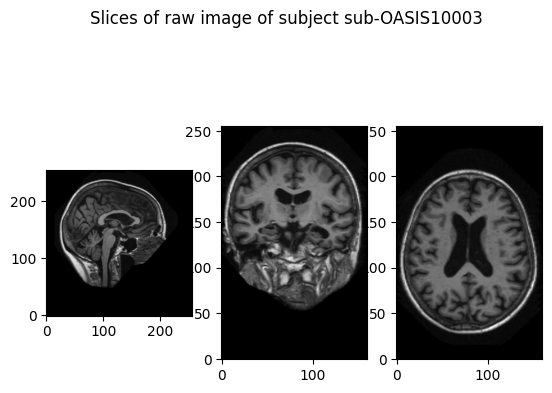

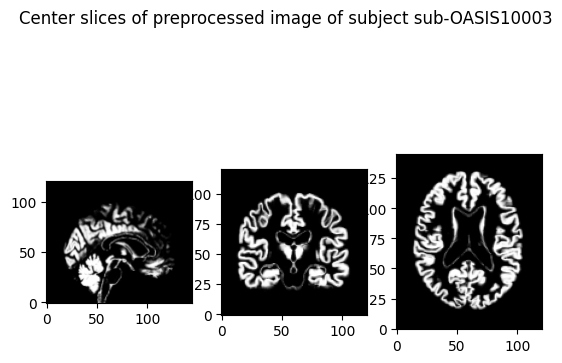

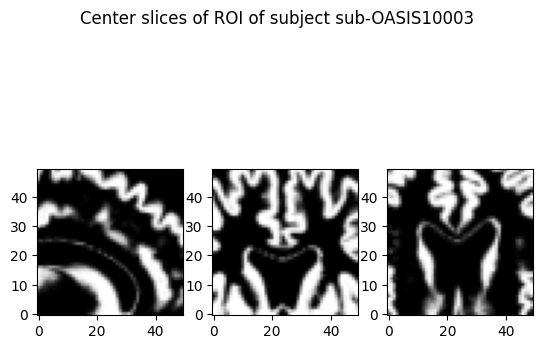

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'/content/drive/MyDrive/AD-DL/OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    f'deeplearning_prepare_data/image_based/custom/{subject}_ses-M00_' +
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
raw_nii = nib.load(f'/content/drive/MyDrive/AD-DL/OASIS-1_dataset/raw/{subject}_ses-M00_T1w.nii.gz')

img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')

raw_np = raw_nii.get_fdata()

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = raw_np[:, :, 78]
slice_1 = raw_np[122, :, :]
slice_2 = raw_np[:, 173, :]
show_slices([slice_0, rotate(slice_1, 90), rotate(slice_2, 90)])
plt.suptitle(f'Slices of raw image of subject {subject}')
plt.show()
print()

slice_0 = preprocessed_pt[0, 60, :, :]
slice_1 = preprocessed_pt[0, :, 72, :]
slice_2 = preprocessed_pt[0, :, :, 60]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of preprocessed image of subject {subject}')
plt.show()
print()

ROI_pt = MRIDatasetRoi(img_dir, OASIS_df)(preprocessed_pt)
slice_0 = ROI_pt[0, 15, :, :]
slice_1 = ROI_pt[0, :, 20, :]
slice_2 = ROI_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of ROI of subject {subject}')
plt.show()

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
batch_size = 4

transform = ROI()

example_dataset = MRIDataset(img_dir, OASIS_df, transform=transform)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

# Shape 

In [ ]:
from torch import nn

conv_layer = nn.Conv3d(1, 8, 3)
print('Weights shape\n', conv_layer.weight.shape)
print()
print('Bias shape\n', conv_layer.bias.shape)

Weights shape
 torch.Size([8, 1, 3, 3, 3])

Bias shape
 torch.Size([8])


In [ ]:
batch_layer = nn.BatchNorm3d(16)
print('Gamma value\n', batch_layer.state_dict()['weight'].shape)
print()
print('Beta value\n', batch_layer.state_dict()['bias'].shape)

Gamma value
 torch.Size([16])

Beta value
 torch.Size([16])


In [ ]:
dropout = nn.Dropout(0.5)
input_tensor = torch.rand(10)
output_tensor = dropout(input_tensor)
print("Input \n", input_tensor)
print()
print("Output \n", output_tensor)

Input 
 tensor([0.1439, 0.5287, 0.4149, 0.1083, 0.1062, 0.0257, 0.3049, 0.1982, 0.0518,
        0.8927])

Output 
 tensor([0.0000, 0.0000, 0.0000, 0.2166, 0.2124, 0.0514, 0.6099, 0.3965, 0.1035,
        1.7854])


In [ ]:
fc = nn.Linear(16, 2)
print("Weights shape \n", fc.weight.shape)
print()
print("Bias shape \n", fc.bias.shape)

Weights shape 
 torch.Size([2, 16])

Bias shape 
 torch.Size([2])


# Train

In [ ]:
class PadMaxPool3d(nn.Module):
    """A MaxPooling module which deals with odd sizes with padding"""
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride - f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output

class CropMaxUnpool3d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(CropMaxUnpool3d, self).__init__()
        self.unpool = nn.MaxUnpool3d(kernel_size, stride)

    def forward(self, f_maps, indices, padding=None):
        output = self.unpool(f_maps, indices)
        if padding is not None:
            x1 = padding[4]
            y1 = padding[2]
            z1 = padding[0]
            output = output[:, :, x1::, y1::, z1::]

        return output

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size

    def forward(self, input):
        return input.view(*self.size)

In [ ]:
class Conv4_FC3(nn.Module):
    def __init__(self, dropout=0, n_classes=2):
        super(Conv4_FC3, self).__init__()

        self.features = nn.Sequential(
            # Convolutions
            nn.Conv3d(1, 15, 3),
            nn.BatchNorm3d(15),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(15, 25, 3),
            nn.BatchNorm3d(25),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(25, 50, 3),
            nn.BatchNorm3d(50),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(50, 50, 3),
            nn.BatchNorm3d(50),
            nn.ReLU(),
            PadMaxPool3d(2, 2)

        )
        self.classifier = nn.Sequential(
            # Fully connected layers
            Flatten(),

            nn.Dropout(p=dropout),
            nn.Linear(50 * 2 * 2 * 2, 50),
            nn.ReLU(),

            nn.Dropout(p=dropout),
            nn.Linear(50, 40),
            nn.ReLU(),

            nn.Linear(40, n_classes)
        )

        self.flattened_shape = [-1, 50, 2, 2, 2]

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

# AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self, model=None):
        from copy import deepcopy
        super(AutoEncoder, self).__init__()

        self.level = 0

        if model is not None:
            self.encoder = deepcopy(model.features)
            self.decoder = self.construct_inv_layers(model)

            for i, layer in enumerate(self.encoder):
                if isinstance(layer, PadMaxPool3d):
                    self.encoder[i].set_new_return()
                elif isinstance(layer, nn.MaxPool3d):
                    self.encoder[i].return_indices = True
        else:
            self.encoder = nn.Sequential()
            self.decoder = nn.Sequential()

    def __len__(self):
        return len(self.encoder)

    def forward(self, x):

        indices_list = []
        pad_list = []
        for layer in self.encoder:
            if isinstance(layer, PadMaxPool3d):
                x, indices, pad = layer(x)
                indices_list.append(indices)
                pad_list.append(pad)
            elif isinstance(layer, nn.MaxPool3d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)
        code = x.view(x.size(0), -1)
        for layer in self.decoder:
            if isinstance(layer, CropMaxUnpool3d):
                x = layer(x, indices_list.pop(), pad_list.pop())
            elif isinstance(layer, nn.MaxUnpool3d):
                x = layer(x, indices_list.pop())
            else:
                x = layer(x)

        return code, x

    def construct_inv_layers(self, model):
        inv_layers = []
        for i, layer in enumerate(self.encoder):
            if isinstance(layer, nn.Conv3d):
                inv_layers.append(nn.ConvTranspose3d(layer.out_channels, layer.in_channels, layer.kernel_size,
                                                     stride=layer.stride, padding=layer.padding))
                self.level += 1
            elif isinstance(layer, PadMaxPool3d):
                inv_layers.append(CropMaxUnpool3d(layer.kernel_size, stride=layer.stride))
            elif isinstance(layer, nn.MaxPool3d):
                inv_layers.append(nn.MaxUnpool3d(layer.kernel_size, stride=layer.stride))
            elif isinstance(layer, nn.Linear):
                inv_layers.append(nn.Linear(layer.out_features, layer.in_features))
            elif isinstance(layer, Flatten):
                inv_layers.append(Reshape(model.flattened_shape))
            elif isinstance(layer, nn.LeakyReLU):
                inv_layers.append(nn.LeakyReLU(negative_slope=1 / layer.negative_slope))
            else:
                inv_layers.append(deepcopy(layer))
        inv_layers = self.replace_relu(inv_layers)
        inv_layers.reverse()
        return nn.Sequential(*inv_layers)

    @staticmethod
    def replace_relu(inv_layers):
        idx_relu, idx_conv = -1, -1
        for idx, layer in enumerate(inv_layers):
            if isinstance(layer, nn.ConvTranspose3d):
                idx_conv = idx
            elif isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU):
                idx_relu = idx

            if idx_conv != -1 and idx_relu != -1:
                inv_layers[idx_relu], inv_layers[idx_conv] = inv_layers[idx_conv], inv_layers[idx_relu]
                idx_conv, idx_relu = -1, -1

        # Check if number of features of batch normalization layers is still correct
        for idx, layer in enumerate(inv_layers):
            if isinstance(layer, nn.BatchNorm3d):
                conv = inv_layers[idx + 1]
                inv_layers[idx] = nn.BatchNorm3d(conv.out_channels)

        return inv_layers

In [ ]:
# Autoencoder train/test
def trainAE(model, train_loader, criterion, optimizer, n_epochs):
    best_model = deepcopy(model)
    train_best_loss = np.inf

    loss_valid = None

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # Retrieve mini-batch
            images, labels = data['image'].cuda(), data['label'].cuda()
            # Forward pass + loss computation
            _, outputs = model((images))
            loss = criterion(outputs, images)
            # Back-propagation
            loss.backward()
            del images, outputs
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        loss_train = testAE(model, train_loader, criterion)
        mean_loss_train = loss_train / (len(train_loader) * train_loader.batch_size)

        print(f'Epoch {epoch}: loss = {mean_loss_train:.6f}')
        
        if mean_loss_train < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = mean_loss_train

    return best_model

def testAE(model, data_loader, criterion):
    model.eval()
    data_loader.dataset.eval()
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            _, outputs = model((images))
            loss = criterion(outputs, images)
            total_loss += loss.item()

            del images, outputs, loss

    return total_loss

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')

train_datasetROI = MRIDatasetRoi(img_dir, train_df, transform=transform)
train_loaderROI = DataLoader(train_datasetROI, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

learning_rate = 10**-4
n_epochs = 10
batch_size = 4

AEROI = AutoEncoder(Conv4_FC3()).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AEROI.parameters(), learning_rate)

best_AEROI = trainAE(AEROI, train_loaderROI, criterion, optimizer, n_epochs)

In [ ]:
PATH = os.path.join("/content/drive/MyDrive/AD-DL/weights/AutoEncoder", "Autoencoder.pth")
torch.save(best_AEROI.state_dict(), PATH)

# Train & Validation

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, mode='min', verbose=True):

        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0

        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [ ]:
es = EarlyStopping()

In [ ]:
# CNN train
def train(model, train_loader, criterion, optimizer, n_epochs, patch_size = 50):
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # Retrieve mini-batch and put data on GPU with .cuda()
            images, labels = data['image'].cuda(), data['label'].cuda()
            # Forward pass
            # outputs = model(images)
            # Loss computation
            output, x = model(images)
            loss = criterion(output, labels)
            # loss = criterion(outputs, labels) # TypeError: cross_entropy_loss(): argument ‘input’ (position 1) must be Tensor, not tuple
            # Back-propagation (gradients computation)
            loss.backward()
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        _, train_metrics = test(model, train_loader, criterion)

        print(
            f"Epoch {epoch}: loss = {train_metrics['mean_loss']:.4f}, "
            f"balanced accuracy = {train_metrics['balanced_accuracy']:.4f}"
            )
        
        # Early Stop Check
        if epoch >= 50:
          es(train_metrics['mean_loss'])
          if es.early_stop:
            if patch_size != 50:
              SAVE_PATH = os.path.join("/content/drive/MyDrive/AD-DL", "weights", "Model", f"EarlyStop_model{patch_size}_epoch_{epoch+1}.pth")
            else:
              SAVE_PATH = os.path.join("/content/drive/MyDrive/AD-DL", "weights", "Model", f"EarlyStop_model_epoch_{epoch+1}.pth")
            torch.save(best_model.state_dict(), SAVE_PATH)
            print(f"Early Stop : {epoch}")
            break
        
        # epoch 25마다 모델 저장 (24, 49, 74, 99)
        if (epoch==24) or (epoch==49) or (epoch==74) or (epoch==99):
          if patch_size != 50:
            SAVE_PATH = os.path.join("/content/drive/MyDrive/AD-DL", "weights", "Model", f"best_model{patch_size}_epoch_{epoch+1}.pth")
          else:
            SAVE_PATH = os.path.join("/content/drive/MyDrive/AD-DL", "weights", "Model", f"best_model_epoch_{epoch+1}.pth")
          torch.save(best_model.state_dict(), SAVE_PATH)
          print(f"Model save : {epoch+1}")
        
        if train_metrics['mean_loss'] < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = train_metrics['mean_loss']

    return best_model

def test(model, data_loader, criterion, test = False):
    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            # outputs = model(images)
            output, x = model(images)
            loss = criterion(output, labels)
            # loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = nn.Softmax(dim=1)(output)
            _, predicted = torch.max(output.data, 1)

            for idx, sub in enumerate(data['participant_id']):
                row = [sub,
                       probs[idx, 0].item(), probs[idx, 1].item(),
                       labels[idx].item(), predicted[idx].item()]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])

    results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
    results_df.reset_index(inplace=True, drop=True)
    results_metrics['mean_loss'] = total_loss / len(data_loader.dataset)

    if test == True:
      print(f"test loss : {results_metrics['mean_loss']:.2f}")

    return results_df, results_metrics


def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2

    return metrics_dict

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_datasetROI = MRIDatasetRoi(img_dir, train_df, transform=transform)
valid_datasetROI = MRIDatasetRoi(img_dir, valid_df, transform=transform)

learning_rate = 10**-4
n_epochs = 100
batch_size = 4

# modelROI = best_AEROI.cuda()
modelROI = AutoEncoder(Conv4_FC3()).cuda()
modelROI.load_state_dict(torch.load("/content/drive/MyDrive/AD-DL/weights/AutoEncoder/Autoencoder.pth"))

train_loaderROI = DataLoader(train_datasetROI, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loaderROI = DataLoader(valid_datasetROI, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelROI.parameters(), learning_rate)

best_modelROI = train(modelROI, train_loaderROI, criterion, optimizer, n_epochs)

valid_resultsROI_df, valid_metricsROI = test(best_modelROI, valid_loaderROI, criterion)
train_resultsROI_df, train_metricsROI = test(best_modelROI, train_loaderROI, criterion)
print()
print(valid_metricsROI)
print(train_metricsROI)

Epoch 0: loss = 0.3081, balanced accuracy = 0.5623
Epoch 1: loss = 0.1340, balanced accuracy = 0.6504
Epoch 2: loss = 0.1179, balanced accuracy = 0.6545
Epoch 3: loss = 0.1198, balanced accuracy = 0.5849
Epoch 4: loss = 0.1065, balanced accuracy = 0.7028
Epoch 5: loss = 0.0942, balanced accuracy = 0.6562
Epoch 6: loss = 0.0939, balanced accuracy = 0.7497
Epoch 7: loss = 0.0806, balanced accuracy = 0.6210
Epoch 8: loss = 0.0740, balanced accuracy = 0.7469
Epoch 9: loss = 0.0659, balanced accuracy = 0.7635
Epoch 10: loss = 0.0587, balanced accuracy = 0.8797
Epoch 11: loss = 0.0512, balanced accuracy = 0.8407
Epoch 12: loss = 0.0431, balanced accuracy = 0.9269
Epoch 13: loss = 0.0377, balanced accuracy = 0.8859
Epoch 14: loss = 0.0472, balanced accuracy = 0.9773
Epoch 15: loss = 0.0346, balanced accuracy = 0.9897
Epoch 16: loss = 0.0205, balanced accuracy = 1.0000
Epoch 17: loss = 0.0184, balanced accuracy = 0.9979
Epoch 18: loss = 0.0127, balanced accuracy = 1.0000
Epoch 19: loss = 0.011

In [ ]:
valid_resultsROI_df = valid_resultsROI_df.merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_resultsROI_old_df = valid_resultsROI_df[(valid_resultsROI_df.age_bl >= 62)]
compute_metrics(valid_resultsROI_old_df.true_label, valid_resultsROI_old_df.predicted_label)

{'accuracy': 0.6,
 'sensitivity': 0.4166666666666667,
 'specificity': 0.7692307692307693,
 'balanced_accuracy': 0.592948717948718}

# Test

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()
criterion = torch.nn.CrossEntropyLoss()

test_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/test.tsv', sep='\t')
test_datasetROI = MRIDatasetRoi(img_dir, test_df, transform=transform)

MODEL_PATH = "/content/drive/MyDrive/AD-DL/weights/Model/EarlyStop_model_epoch_69.pth"

modelROI = AutoEncoder(Conv4_FC3()).cuda()
modelROI.load_state_dict(torch.load(MODEL_PATH)) 

test_loaderROI = DataLoader(test_datasetROI, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test_resultsROI_df, test_metricsROI = test(modelROI, test_loaderROI, criterion, test = True)
print(f"test accuracy : {test_metricsROI['accuracy']}")

test loss : 0.05
test accuracy : 0.8


In [ ]:
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

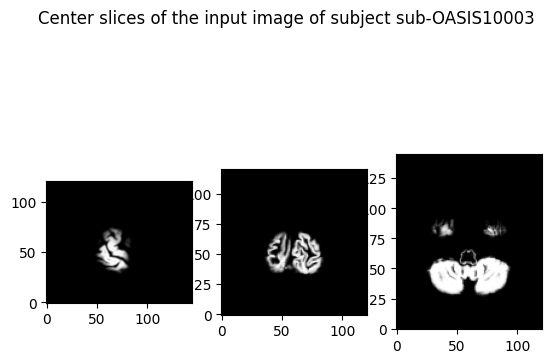

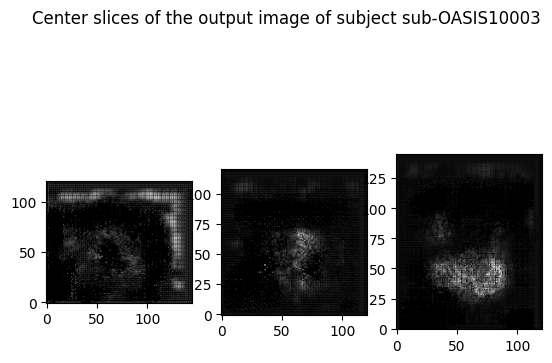

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'/content/drive/MyDrive/AD-DL/OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    'deeplearning_prepare_data/image_based/custom/' + subject +
                    '_ses-M00_'+
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')

input_pt = MinMaxNormalization()(preprocessed_pt).unsqueeze(0).cuda()
_, output_pt = modelROI(input_pt)


slice_0 = input_pt[0, 0, 15, :, :].cpu()
slice_1 = input_pt[0, 0, :, 20, :].cpu()
slice_2 = input_pt[0, 0, :, :, 15].cpu()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of the input image of subject {subject}')
plt.show()
print()

slice_0 = output_pt[0, 0, 15, :, :].cpu().detach()
slice_1 = output_pt[0, 0, :, 20, :].cpu().detach()
slice_2 = output_pt[0, 0, :, :, 15].cpu().detach()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of the output image of subject {subject}')
plt.show()

# Optional

## 1. patch size : 50x50x50 → 100x100x100

In [ ]:
class MRIDatasetRoi100(MRIDataset):

    def __init__(self, img_dir, data_df, transform=MinMaxNormalization()):
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD": 1, "CN": 0}

        self.size = self[0]['image'].shape

    def __call__(self, img):
      crop_size = (100, 100, 100) # patch를 100*100*100 크기로 잘라줌
      crop_center = (61, 96, 68) # the center of the left hippocampus

      extracted_roi = img[
        :,
        crop_center[0] - crop_size[0] // 2: crop_center[0] + crop_size[0] // 2:,
        crop_center[1] - crop_size[1] // 2: crop_center[1] + crop_size[1] // 2:,
        crop_center[2] - crop_size[2] // 2: crop_center[2] + crop_size[2] // 2:
        ].clone()

      return extracted_roi

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.transform.train()

    def eval(self):
        self.transform.eval()

In [ ]:
class ROI100(object):
  def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
  def __call__(self, img):
    crop_size = (100, 100, 100)
    crop_center = (61, 96, 68)

    extracted_roi = img[
      :,
      crop_center[0] - crop_size[0] // 2: crop_center[0] + crop_size[0] // 2:,
      crop_center[1] - crop_size[1] // 2: crop_center[1] + crop_size[1] // 2:,
      crop_center[2] - crop_size[2] // 2: crop_center[2] + crop_size[2] // 2:
      ].clone()

    return extracted_roi

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
batch_size = 4

transform = MinMaxNormalization()

example_dataset = MRIDataset(img_dir, OASIS_df, transform=transform)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 121, 145, 121])

Shape of DataLoader output:
 torch.Size([4, 1, 121, 145, 121])


In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
batch_size = 4

transform = ROI100()

example_dataset = MRIDatasetRoi100(img_dir, OASIS_df, transform=transform)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 100, 99, 100])

Shape of DataLoader output:
 torch.Size([4, 1, 100, 99, 100])


### AutoEncoder

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')

train_datasetROI100 = MRIDatasetRoi100(img_dir, train_df, transform=transform)
train_loaderROI100 = DataLoader(train_datasetROI100, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

learning_rate = 10**-4
n_epochs = 10
batch_size = 4

AEROI100 = AutoEncoder(Conv4_FC3()).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AEROI100.parameters(), learning_rate)

best_AEROI100 = trainAE(AEROI100, train_loaderROI100, criterion, optimizer, n_epochs)

PATH = os.path.join("/content/drive/MyDrive/AD-DL/weights/AutoEncoder", "Autoencoder100.pth")
torch.save(best_AEROI100.state_dict(), PATH)

Epoch 0: loss = 0.042965
Epoch 1: loss = 0.027328
Epoch 2: loss = 0.019978
Epoch 3: loss = 0.016568
Epoch 4: loss = 0.014555
Epoch 5: loss = 0.013377
Epoch 6: loss = 0.010988
Epoch 7: loss = 0.009150
Epoch 8: loss = 0.008331
Epoch 9: loss = 0.007714


### Model

In [ ]:
es = EarlyStopping()

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_datasetROI100 = MRIDatasetRoi100(img_dir, train_df, transform=transform)
valid_datasetROI100 = MRIDatasetRoi100(img_dir, valid_df, transform=transform)

learning_rate = 10**-4
n_epochs = 100
batch_size = 4

modelROI100 = AutoEncoder(Conv4_FC3()).cuda()
modelROI100.load_state_dict(torch.load("/content/drive/MyDrive/AD-DL/weights/AutoEncoder/Autoencoder100.pth"))

train_loaderROI100 = DataLoader(train_datasetROI100, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loaderROI100 = DataLoader(valid_datasetROI100, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelROI100.parameters(), learning_rate)

best_modelROI100 = train(modelROI100, train_loaderROI100, criterion, optimizer, n_epochs, patch_size = 100)

valid_resultsROI100_df, valid_metricsROI100 = test(best_modelROI100, valid_loaderROI100, criterion)
train_resultsROI100_df, train_metricsROI100 = test(best_modelROI100, train_loaderROI100, criterion)
print()
print(valid_metricsROI100)
print(train_metricsROI100)

Epoch 0: loss = 1.1355, balanced accuracy = 0.6489
Epoch 1: loss = 0.1408, balanced accuracy = 0.6324
Epoch 2: loss = 0.1200, balanced accuracy = 0.6401
Epoch 3: loss = 0.1151, balanced accuracy = 0.6790
Epoch 4: loss = 0.1097, balanced accuracy = 0.7191
Epoch 5: loss = 0.0905, balanced accuracy = 0.6259
Epoch 6: loss = 0.0830, balanced accuracy = 0.6800
Epoch 7: loss = 0.0873, balanced accuracy = 0.6907
Epoch 8: loss = 0.0710, balanced accuracy = 0.7055
Epoch 9: loss = 0.0632, balanced accuracy = 0.8238
Epoch 10: loss = 0.0549, balanced accuracy = 0.8452
Epoch 11: loss = 0.0536, balanced accuracy = 0.7997
Epoch 12: loss = 0.0427, balanced accuracy = 0.9183
Epoch 13: loss = 0.0381, balanced accuracy = 0.9441
Epoch 14: loss = 0.0332, balanced accuracy = 0.9548
Epoch 15: loss = 0.0318, balanced accuracy = 0.8686
Epoch 16: loss = 0.0235, balanced accuracy = 0.9979
Epoch 17: loss = 0.0186, balanced accuracy = 0.9979
Epoch 18: loss = 0.0155, balanced accuracy = 1.0000
Epoch 19: loss = 0.016

In [ ]:
# test
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()
criterion = torch.nn.CrossEntropyLoss()

test_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/test.tsv', sep='\t')
test_datasetROI100 = MRIDatasetRoi100(img_dir, test_df, transform=transform)

MODEL_PATH = "/content/drive/MyDrive/AD-DL/weights/Model/EarlyStop_model100_epoch_74.pth"
modelROI100 = AutoEncoder(Conv4_FC3()).cuda()
modelROI100.load_state_dict(torch.load(MODEL_PATH)) 

test_loaderROI100 = DataLoader(test_datasetROI100, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test_resultsROI100_df, test_metricsROI100 = test(modelROI100, test_loaderROI100, criterion, test = True)
print(f"test accuracy : {test_metricsROI100['accuracy']}")

test loss : 0.07
test accuracy : 0.85


## 2. patch로 자르지 않고 전체로 학습시키기

In [ ]:
class MRIDatasetImage(MRIDataset):
    def __init__(self, img_dir, data_df, transform=None):
        self.elem_index = None
        self.mode = "image"
        super().__init__(img_dir, data_df, transform=None)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
batch_size = 4

example_dataset = MRIDatasetImage(img_dir, OASIS_df)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 121, 145, 121])

Shape of DataLoader output:
 torch.Size([4, 1, 121, 145, 121])


In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')

train_datasetImage = MRIDatasetImage(img_dir, train_df, transform=transform)
train_loaderImage = DataLoader(train_datasetImage, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

learning_rate = 10**-4
n_epochs = 10
batch_size = 4

AEImage = AutoEncoder(Conv4_FC3()).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AEImage.parameters(), learning_rate)

best_AEImage = trainAE(AEImage, train_loaderImage, criterion, optimizer, n_epochs)

PATH = os.path.join("/content/drive/MyDrive/AD-DL/weights/AutoEncoder", "AutoencoderImage.pth")
torch.save(best_AEImage.state_dict(), PATH)

Epoch 0: loss = 0.034270
Epoch 1: loss = 0.020863
Epoch 2: loss = 0.015791
Epoch 3: loss = 0.013131
Epoch 4: loss = 0.010938
Epoch 5: loss = 0.010102
Epoch 6: loss = 0.008499
Epoch 7: loss = 0.007545
Epoch 8: loss = 0.006745
Epoch 9: loss = 0.005913


In [ ]:
es = EarlyStopping()

img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_datasetImage = MRIDatasetImage(img_dir, train_df, transform=transform)
valid_datasetImage = MRIDatasetImage(img_dir, valid_df, transform=transform)

learning_rate = 10**-4
n_epochs = 100
batch_size = 4

modelImage = AutoEncoder(Conv4_FC3()).cuda()
modelImage.load_state_dict(torch.load("/content/drive/MyDrive/AD-DL/weights/AutoEncoder/AutoencoderImage.pth"))

train_loaderImage = DataLoader(train_datasetImage, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loaderImage = DataLoader(valid_datasetImage, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelImage.parameters(), learning_rate)

best_modelImage = train(modelImage, train_loaderImage, criterion, optimizer, n_epochs, patch_size = 0)

valid_resultsImage_df, valid_metricsImage = test(best_modelImage, valid_loaderImage, criterion)
train_resultsImage_df, train_metricsImage = test(best_modelImage, train_loaderImage, criterion)
print()
print(valid_metricsImage)
print(train_metricsImage)

Epoch 0: loss = 2.3002, balanced accuracy = 0.0000


<ipython-input-13-7d2b2d054537>:103: RuntimeWarning: invalid value encountered in long_scalars
  metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)


Epoch 1: loss = 1.7106, balanced accuracy = 0.6617
Epoch 2: loss = 0.2275, balanced accuracy = 0.4958
Epoch 3: loss = 0.1749, balanced accuracy = 0.4876
Epoch 4: loss = 0.1498, balanced accuracy = 0.4983
Epoch 5: loss = 0.1409, balanced accuracy = 0.5376
Epoch 6: loss = 0.1305, balanced accuracy = 0.6028
Epoch 7: loss = 0.1221, balanced accuracy = 0.5593
Epoch 8: loss = 0.1208, balanced accuracy = 0.6676
Epoch 9: loss = 0.1069, balanced accuracy = 0.5869
Epoch 10: loss = 0.0995, balanced accuracy = 0.6411
Epoch 11: loss = 0.0949, balanced accuracy = 0.6976
Epoch 12: loss = 0.0892, balanced accuracy = 0.6255
Epoch 13: loss = 0.1076, balanced accuracy = 0.5345
Epoch 14: loss = 0.0851, balanced accuracy = 0.6966
Epoch 15: loss = 0.0730, balanced accuracy = 0.7486
Epoch 16: loss = 0.0698, balanced accuracy = 0.8287
Epoch 17: loss = 0.0693, balanced accuracy = 0.8611
Epoch 18: loss = 0.0614, balanced accuracy = 0.8283
Epoch 19: loss = 0.0580, balanced accuracy = 0.8656
Epoch 20: loss = 0.05

In [ ]:
# test
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()
criterion = torch.nn.CrossEntropyLoss()

test_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/test.tsv', sep='\t')
test_datasetImage = MRIDatasetImage(img_dir, test_df, transform=transform)

MODEL_PATH = "/content/drive/MyDrive/AD-DL/weights/Model/EarlyStop_model0_epoch_63.pth"
modelImage = AutoEncoder(Conv4_FC3()).cuda()
modelImage.load_state_dict(torch.load(MODEL_PATH)) 

test_loaderImage = DataLoader(test_datasetImage, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test_resultsImage_df, test_metricsImage = test(modelImage, test_loaderImage, criterion, test = True)
print(f"test accuracy : {test_metricsImage['accuracy']}")

test loss : 0.03
test accuracy : 0.85
